### Save WSE and discharge longitudinal profiles for the Llano River

This notebook will calculate longitudinal profile plots for any HUC8, assuming that its composite HAND maps have been calculated.

For correct filepaths, copy this notebook into the HUC8 directory you are analyzing. If that is the Llano River, copy this notebook to the 12090204 directory.

Inside the directory there must be a shapefile with a flow path, a DEM raster, and a composite inundation raster for each inundation scenario. A DEM raster is included in the HUC8 .zip file and a shapefile for the Llano River is linked below.

To create figures for the Llano River, copy this notebook into the 12090204 directory. Ensure these files are also in that directory:
 - `dem_meters.tif`
 - `LlanoRiver.shp` (download [here](https://utexas.box.com/s/0c54i4n3nf4xp41dsfbr9fmwjc7usrjs))
 - 10 composite inundation maps
    - create with the scripts in https://github.com/markwang0/HAND_austin_exercises
    - One composite inundation map for each module
    - Healed and unhealed inundation maps
    - saved with the convention:
      - `inundation/mod{mod}/mod{mod}_{heal_status}_mosaic.tif`
      - e.g. the path to the healed module 3b composite map would be:
      - `inundation/mod3b/mod3b_healed_mosaic.tif`

Figures will be saved inside the HUC8 directory in a folder called `figs` after running this notebook. The data used to create the plots will be saved in `profiles_with_q.csv`.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio as rio


In [2]:
# get xy coords from geopandas dataframe in a given crs
def get_points(gpd_df, dest_crs):
    pts = gpd_df.to_crs(dest_crs).geometry
    coords = [(pt.xy[0][0], pt.xy[1][0]) for pt in pts]
    return coords


# sample rasterio dataset with xy coords
def sample_rio_ds(rio_ds, coords):
    sampled_vals = np.array([x[0] for x in rio_ds.sample(coords)])
    # clean bad values from unfiltered DEM
    sampled_vals[sampled_vals < 0] = 0
    sampled_vals[sampled_vals > 3.4e38] = np.nan
    return sampled_vals


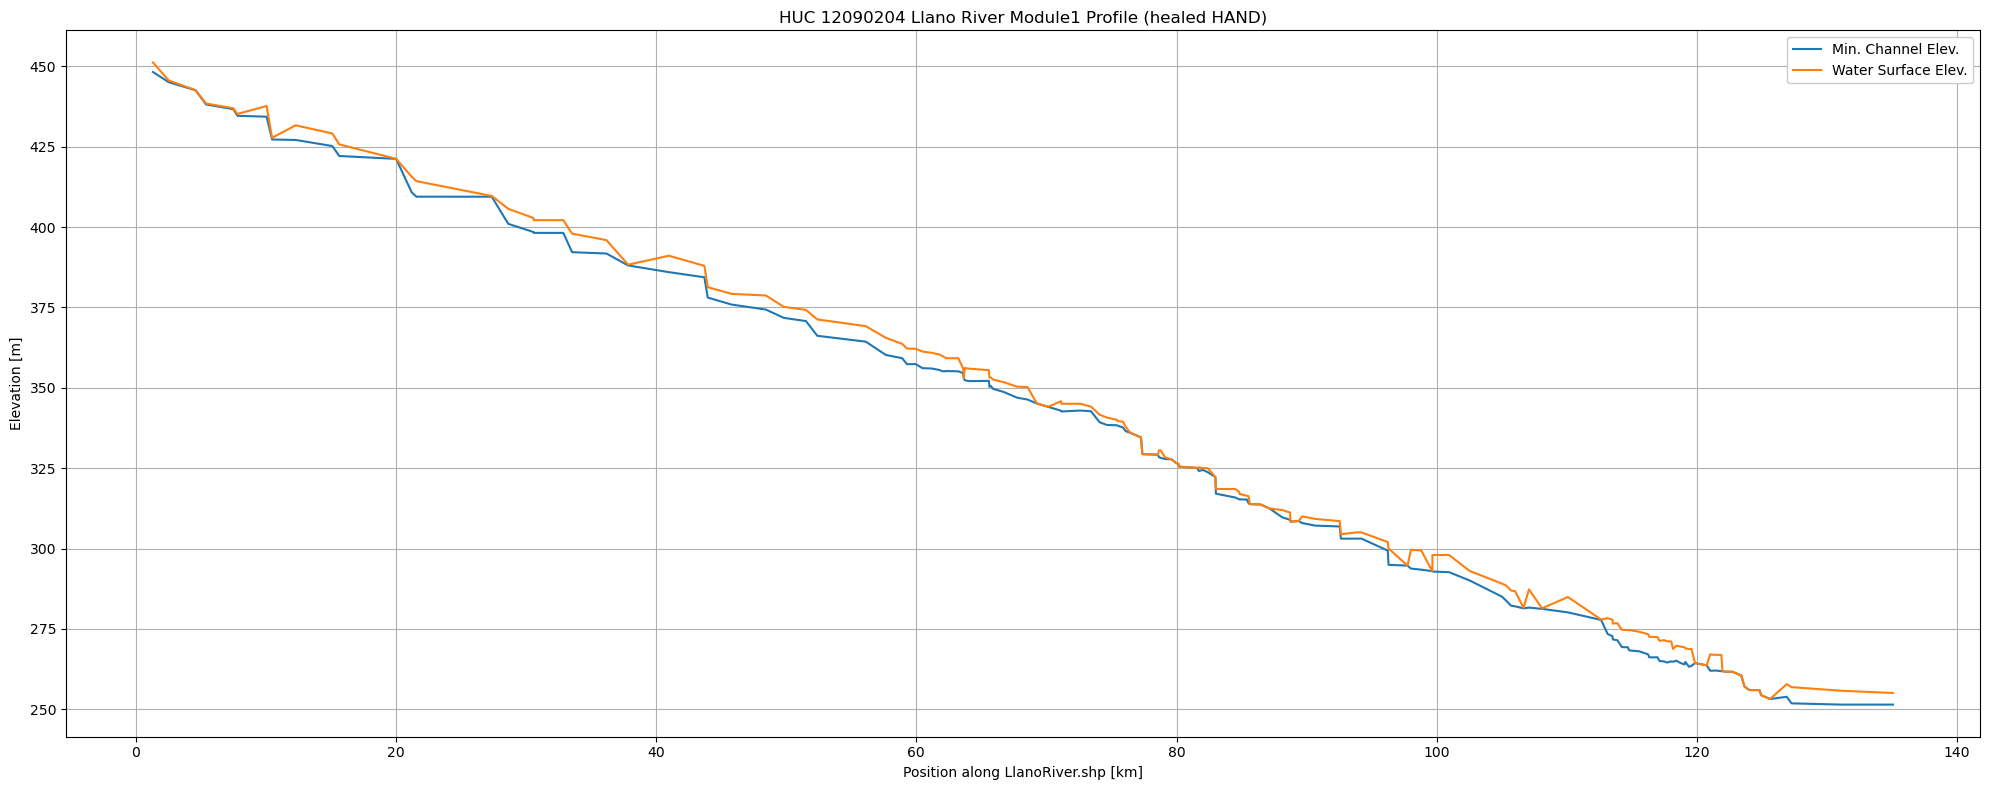

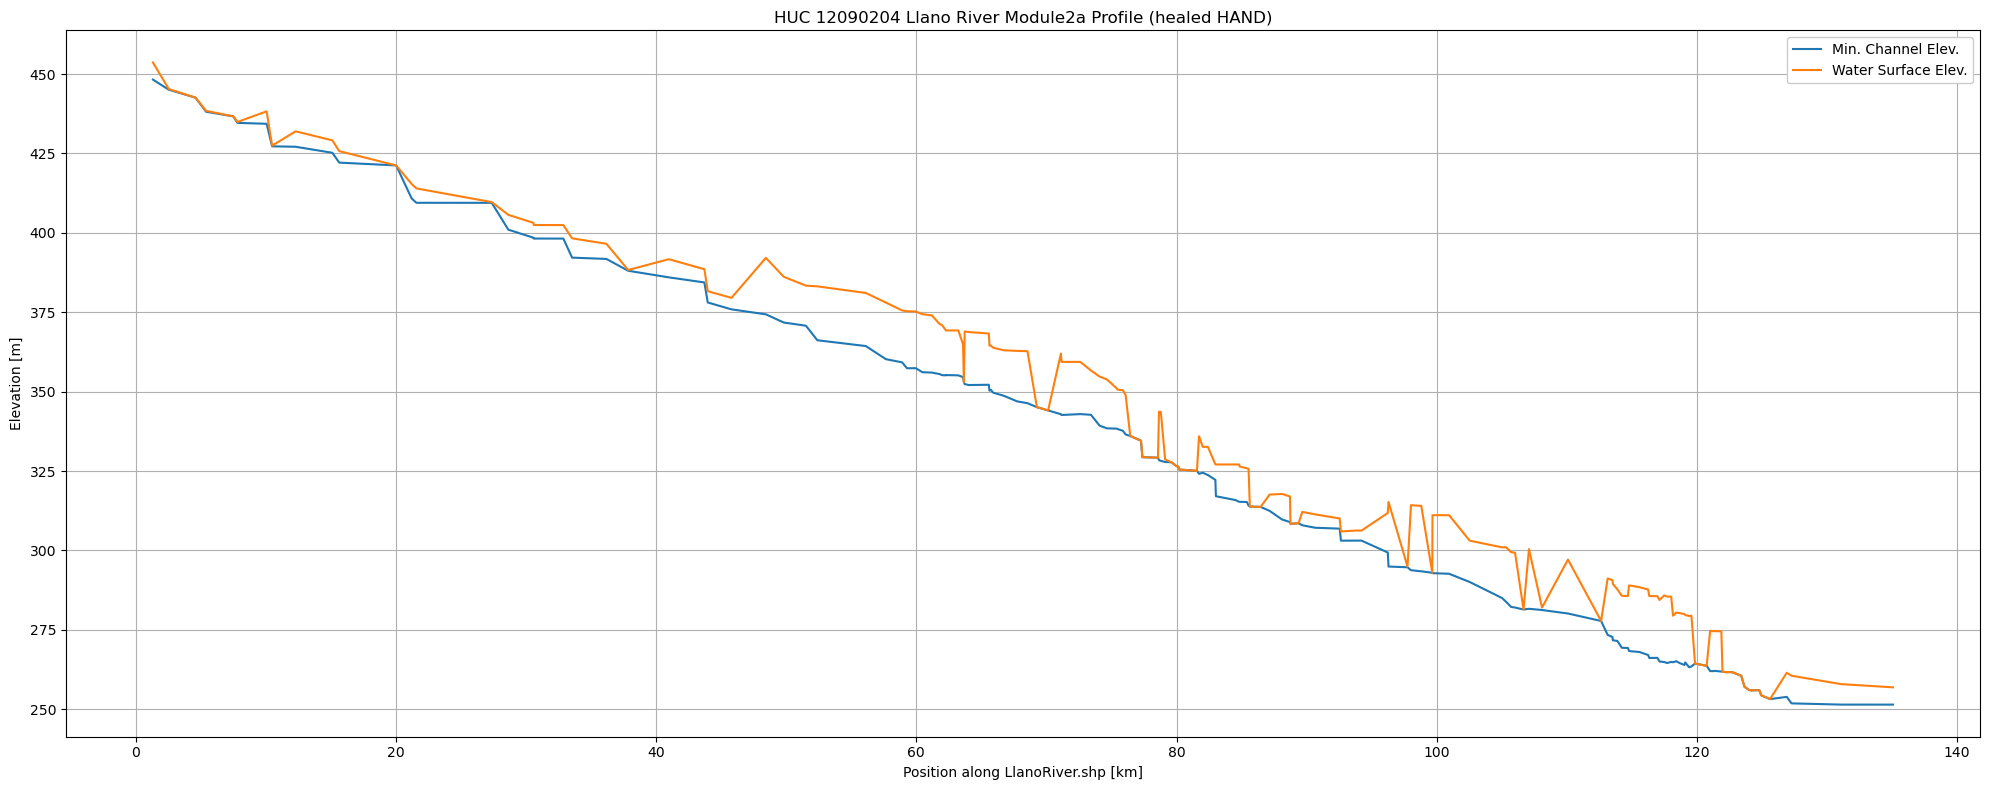

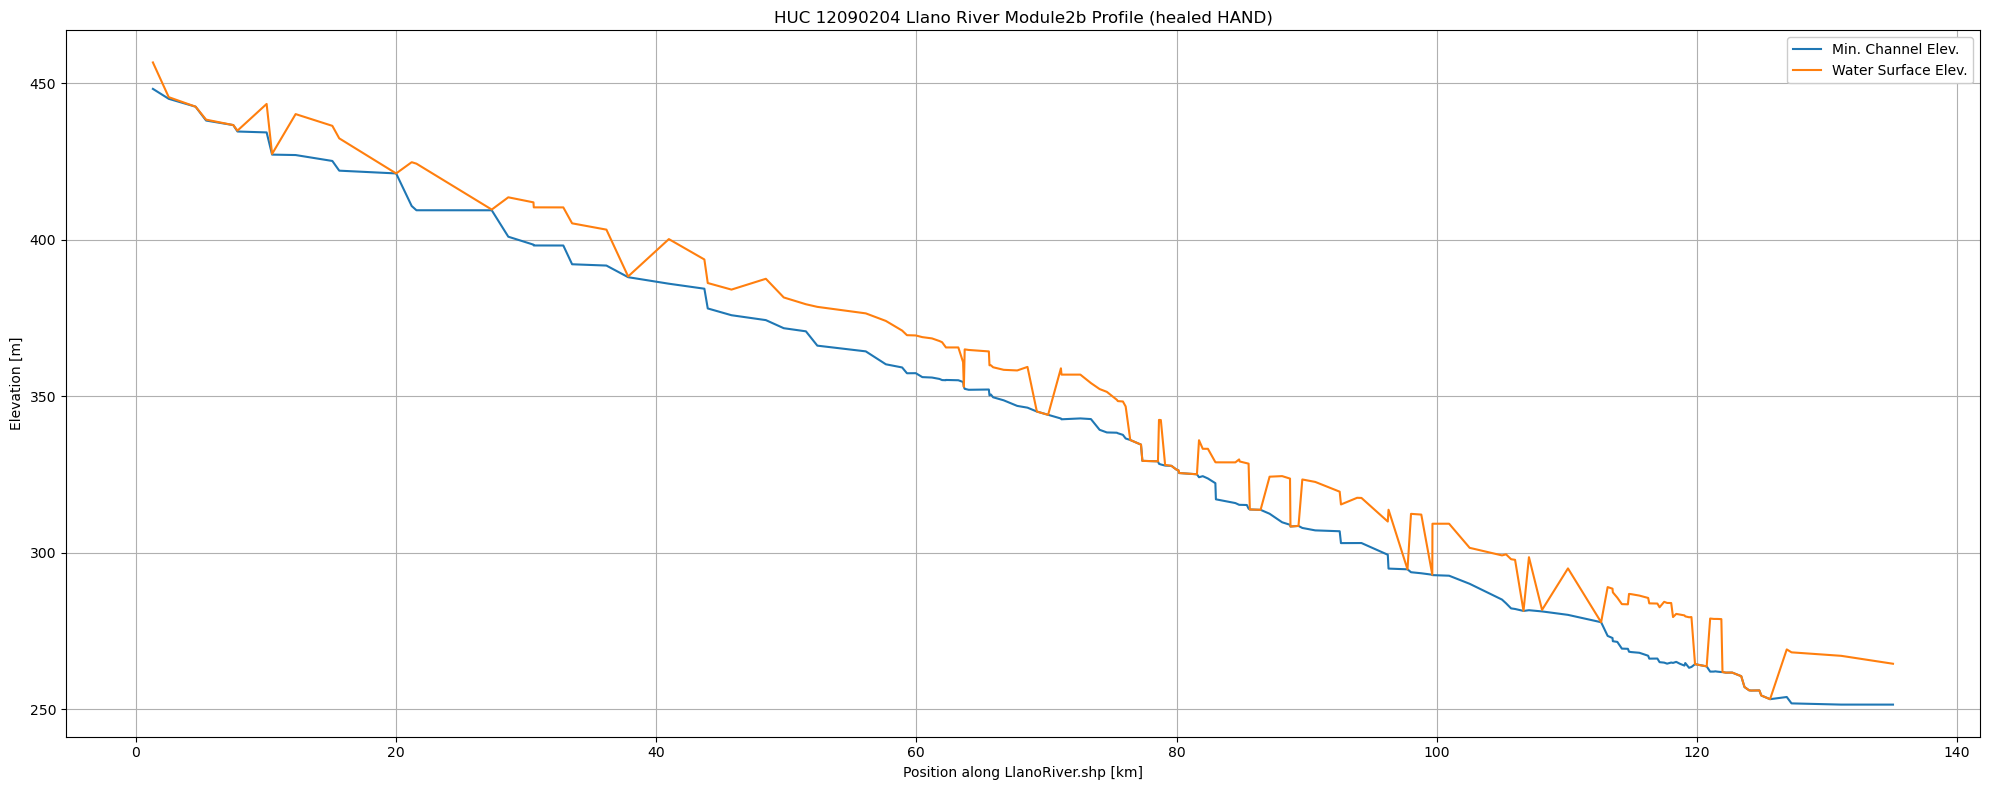

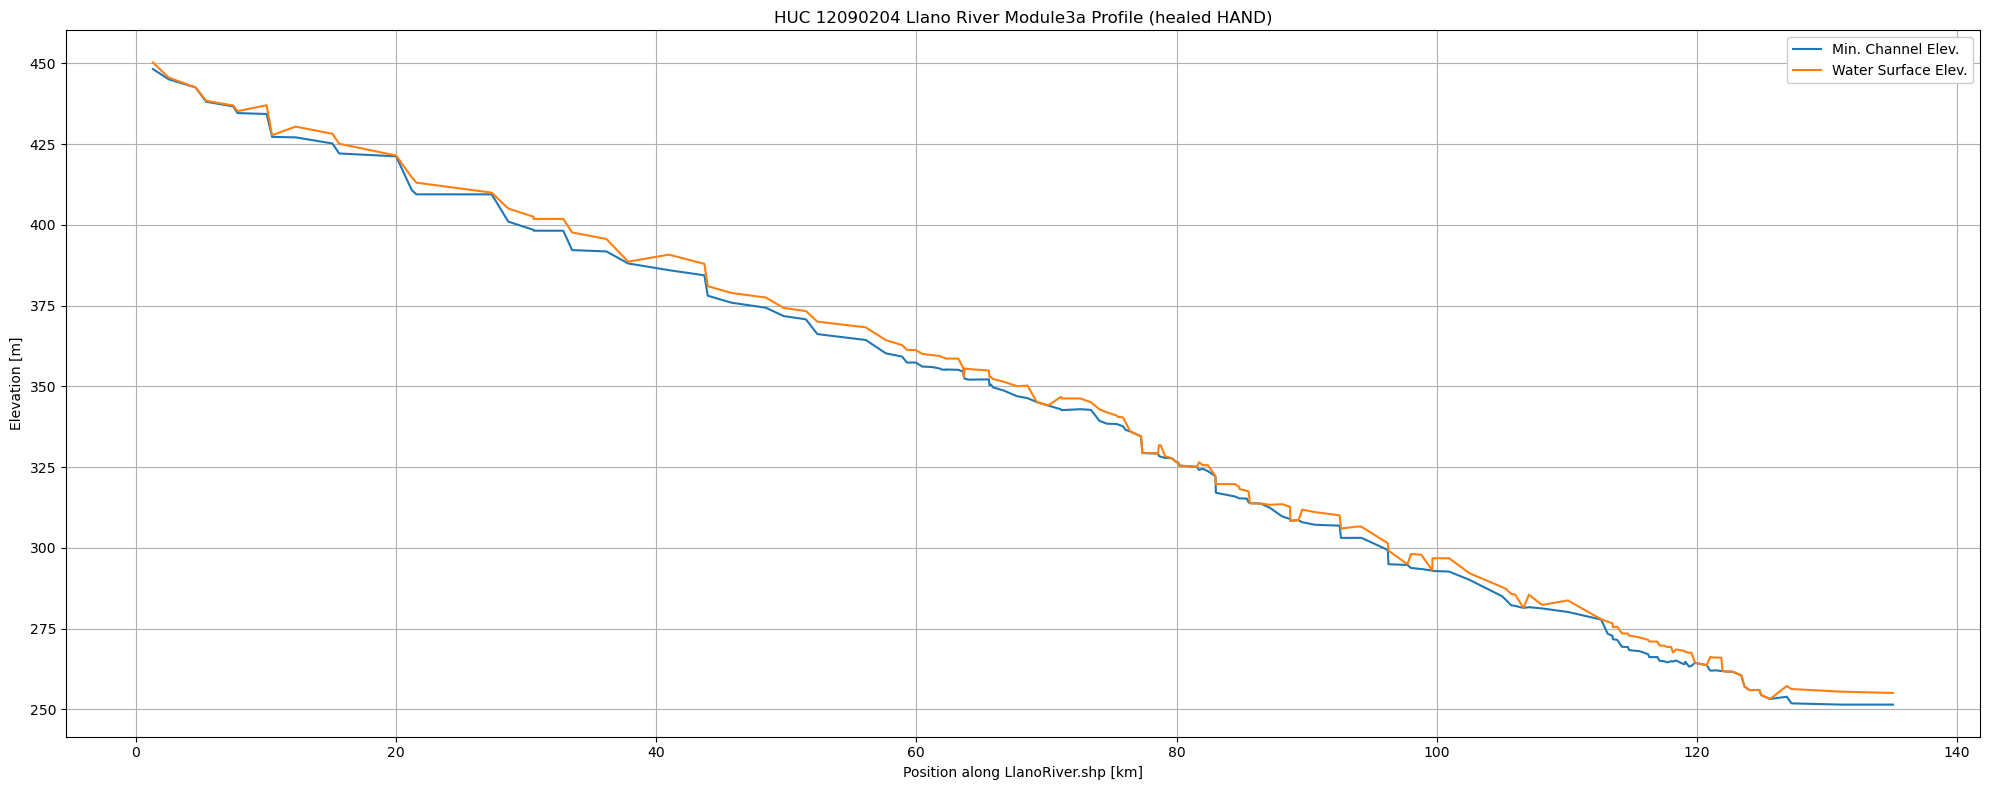

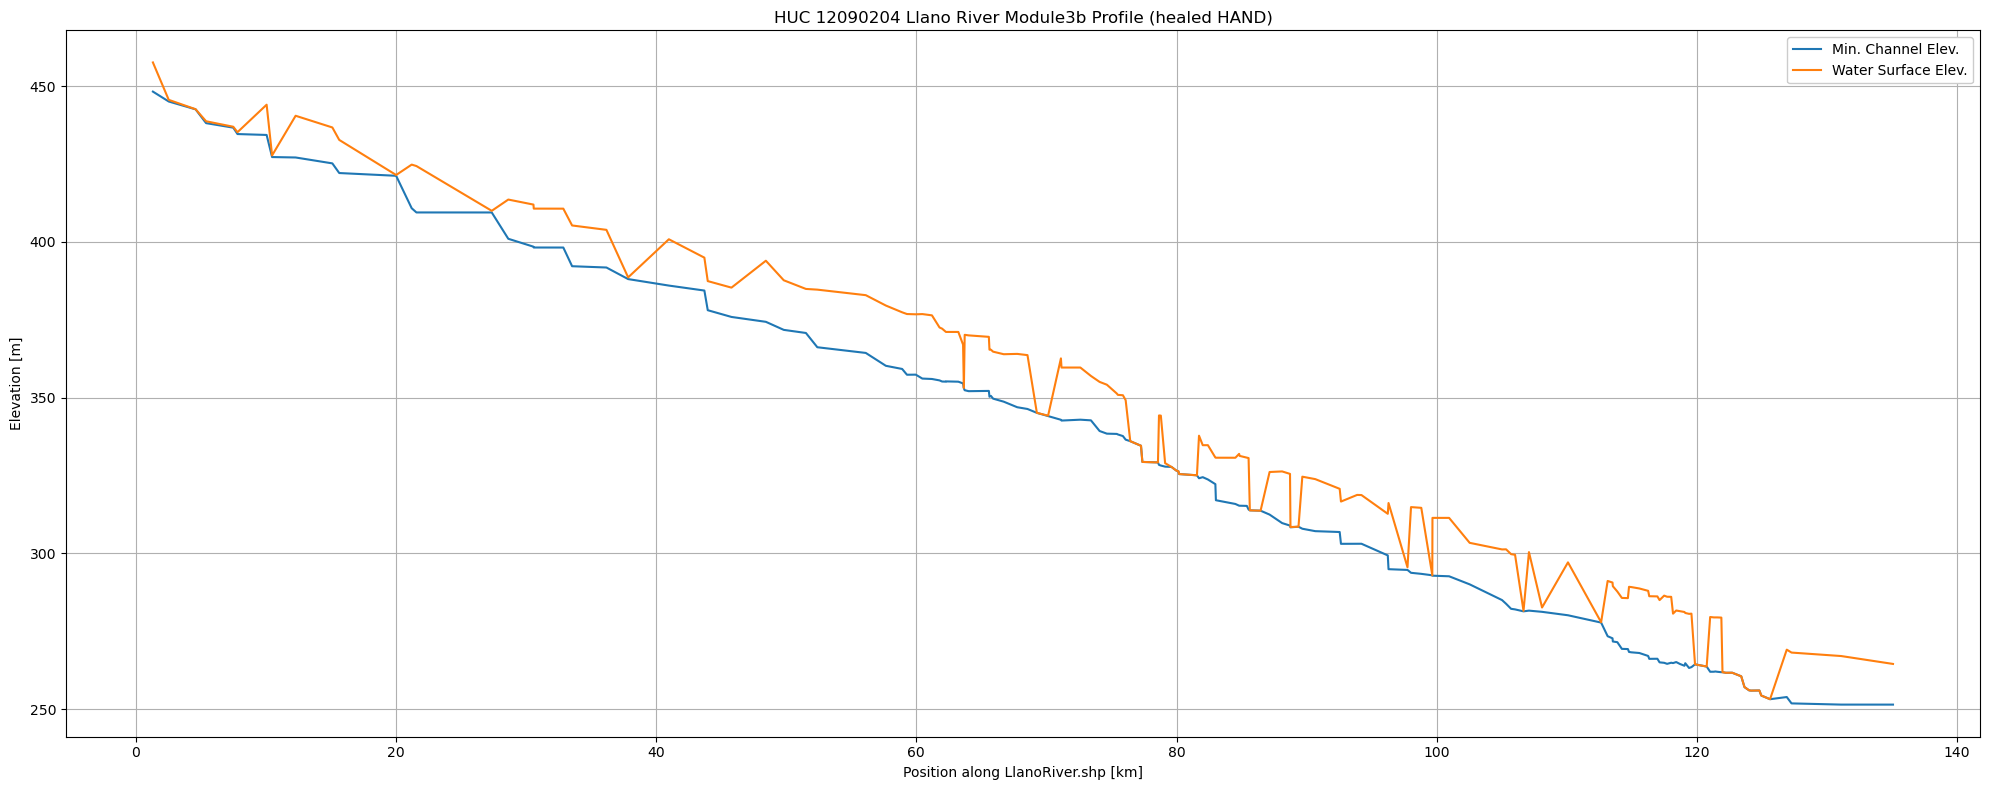

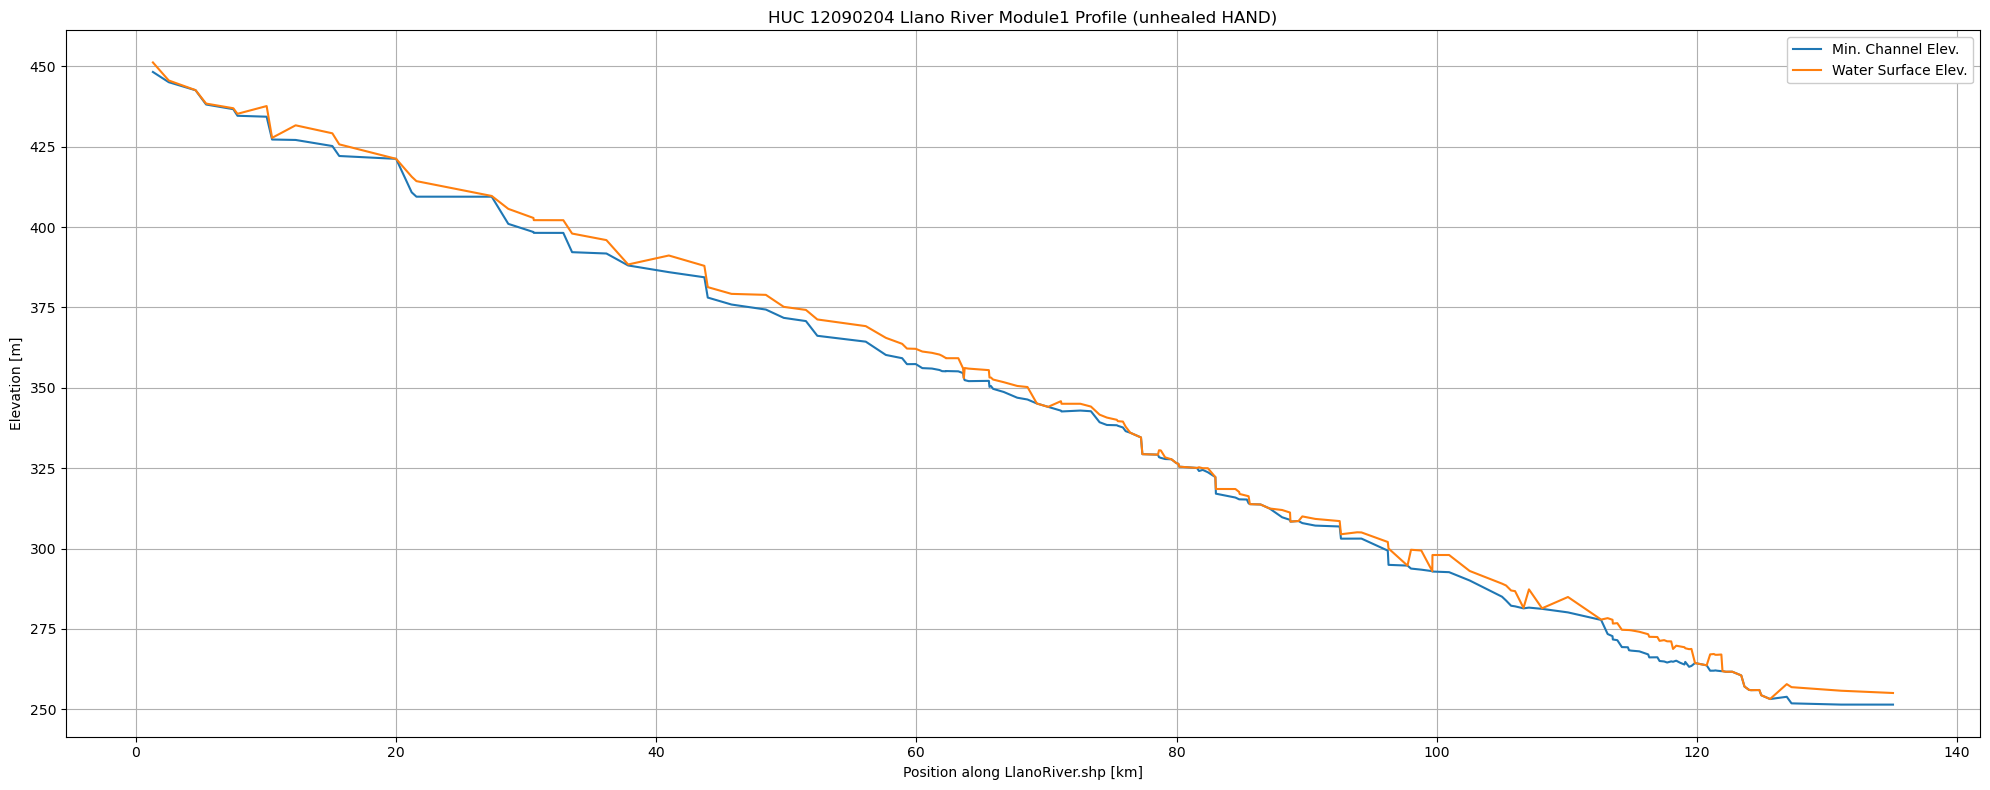

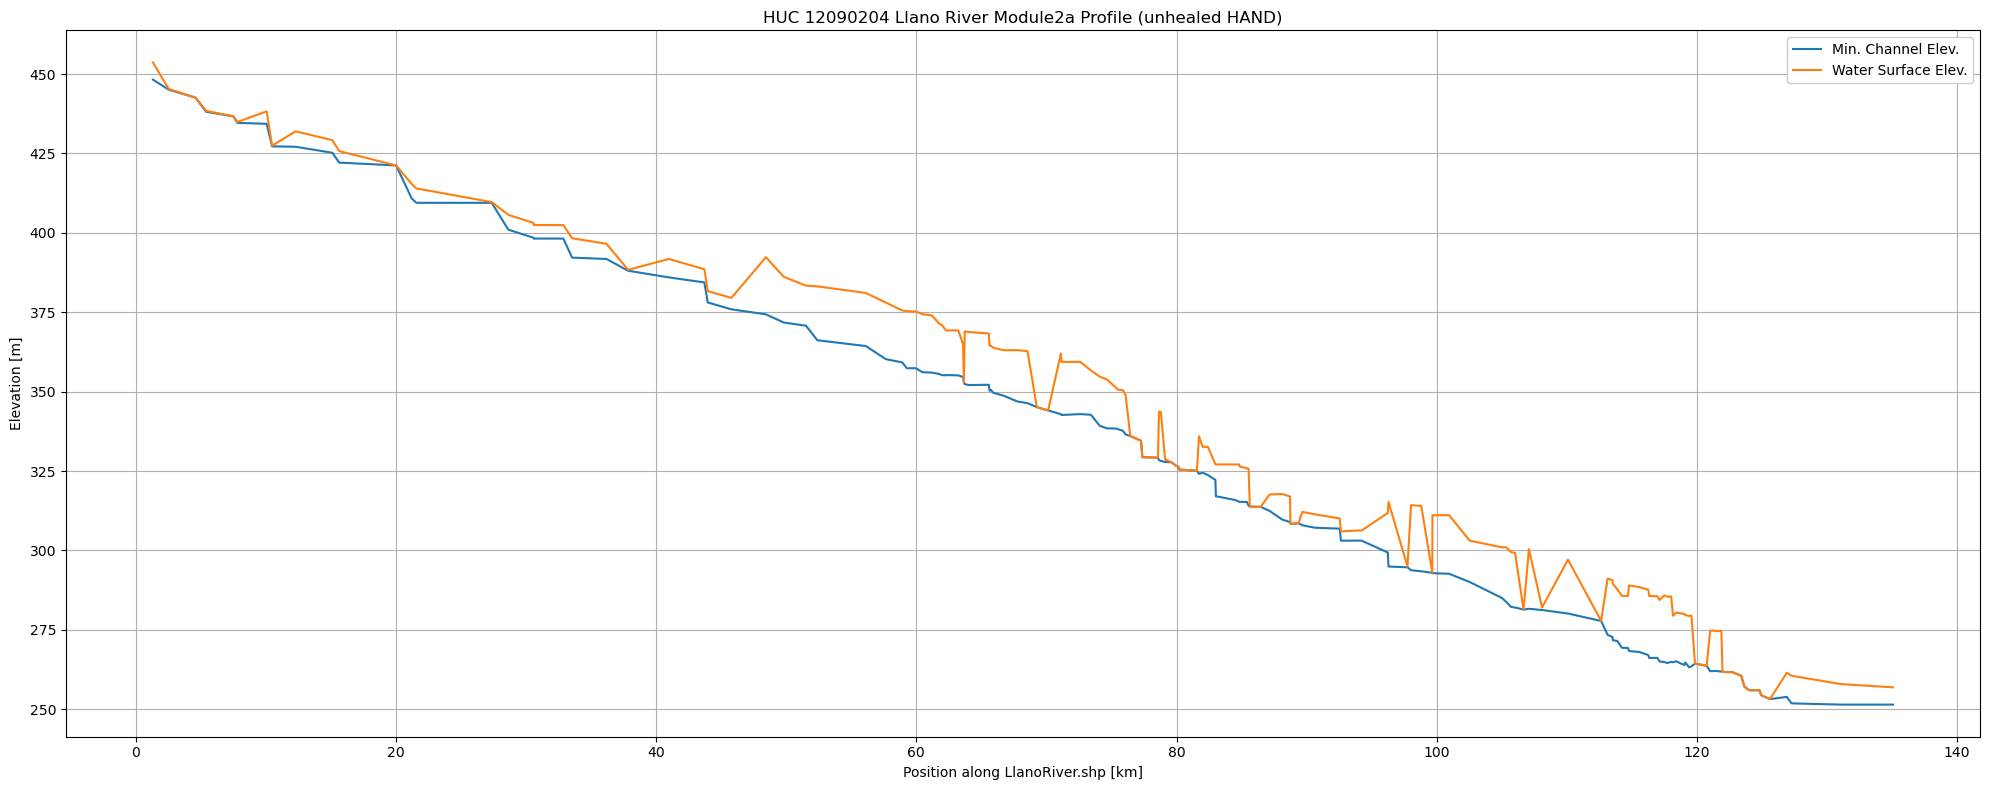

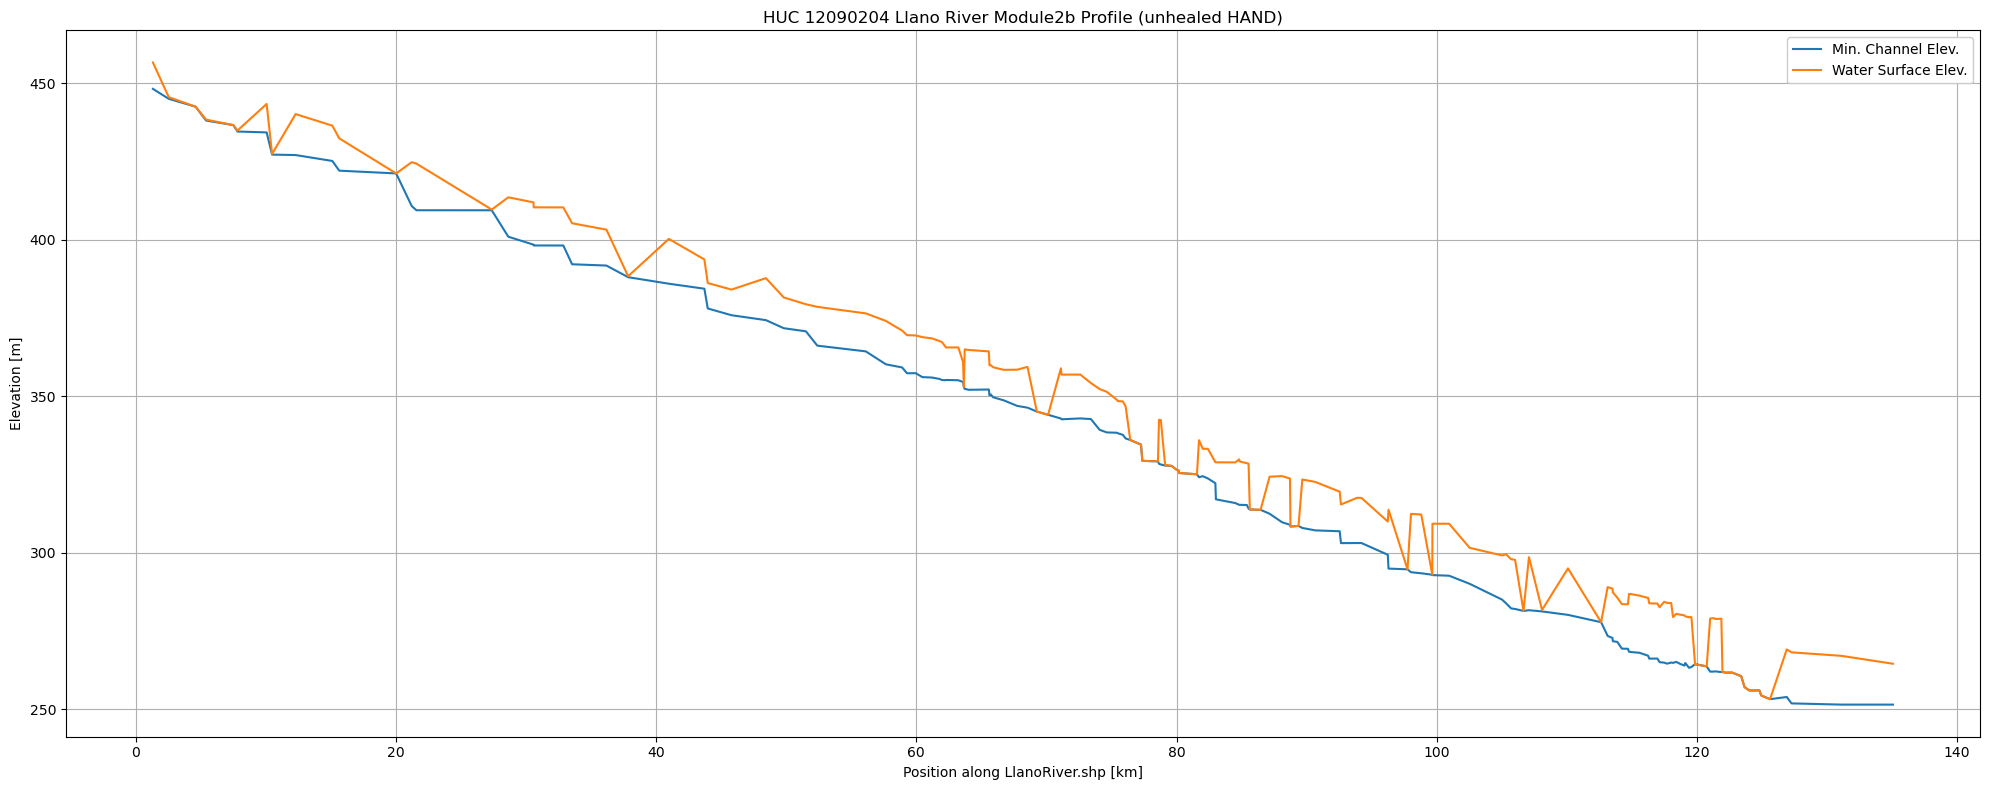

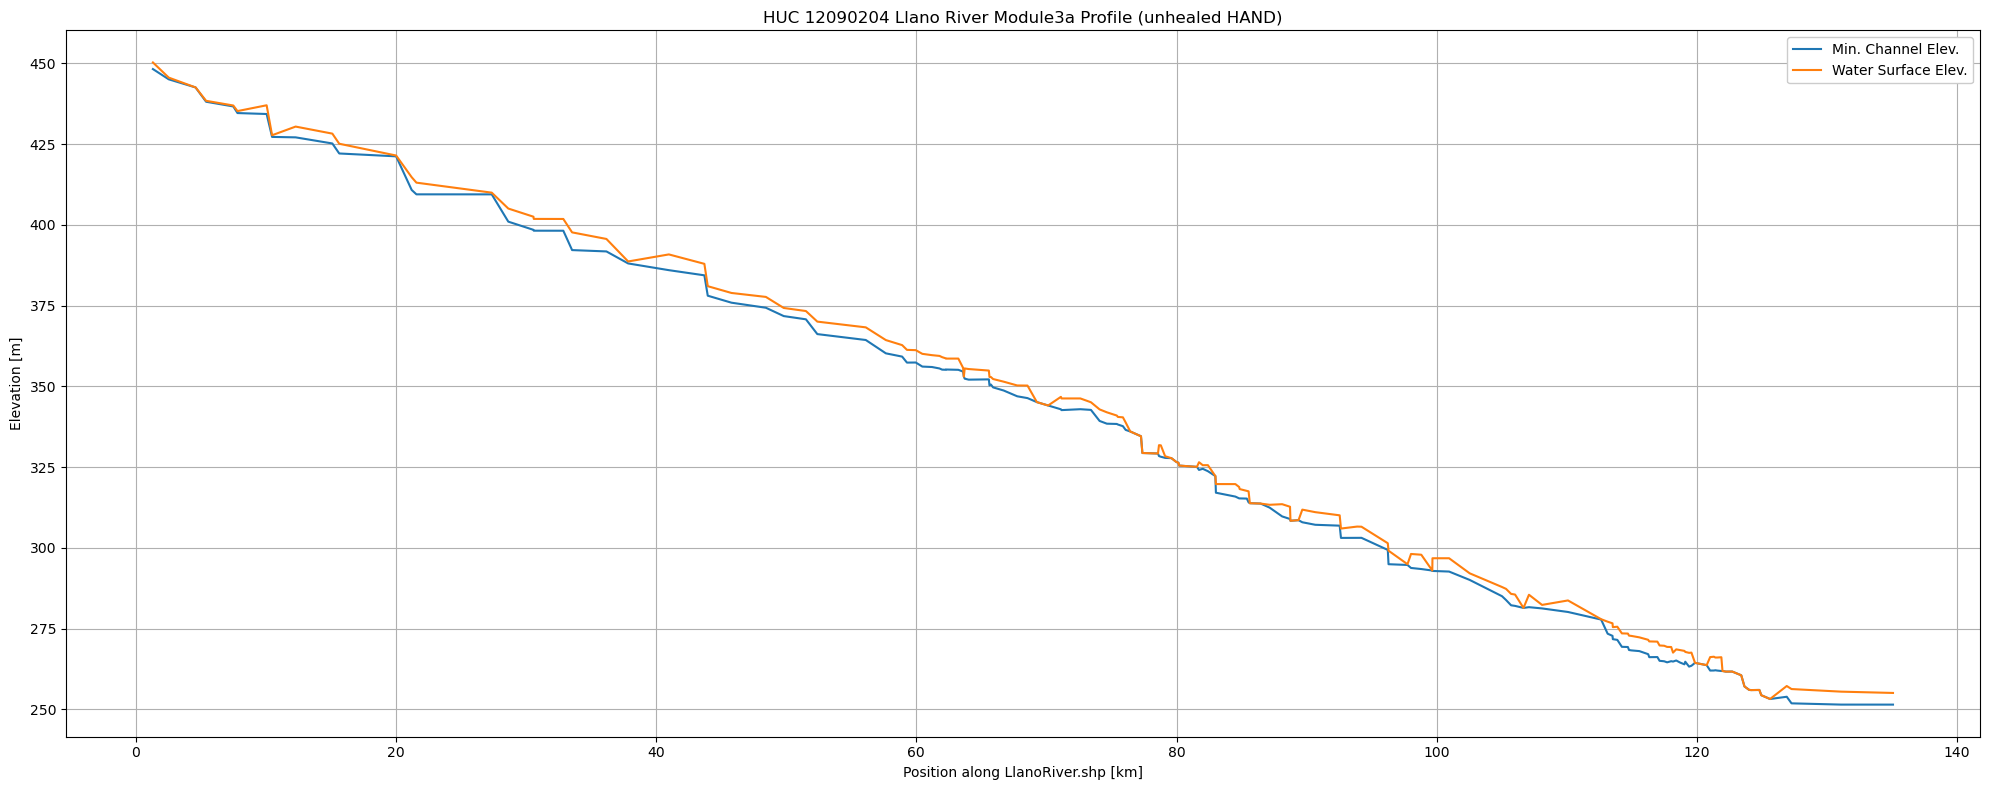

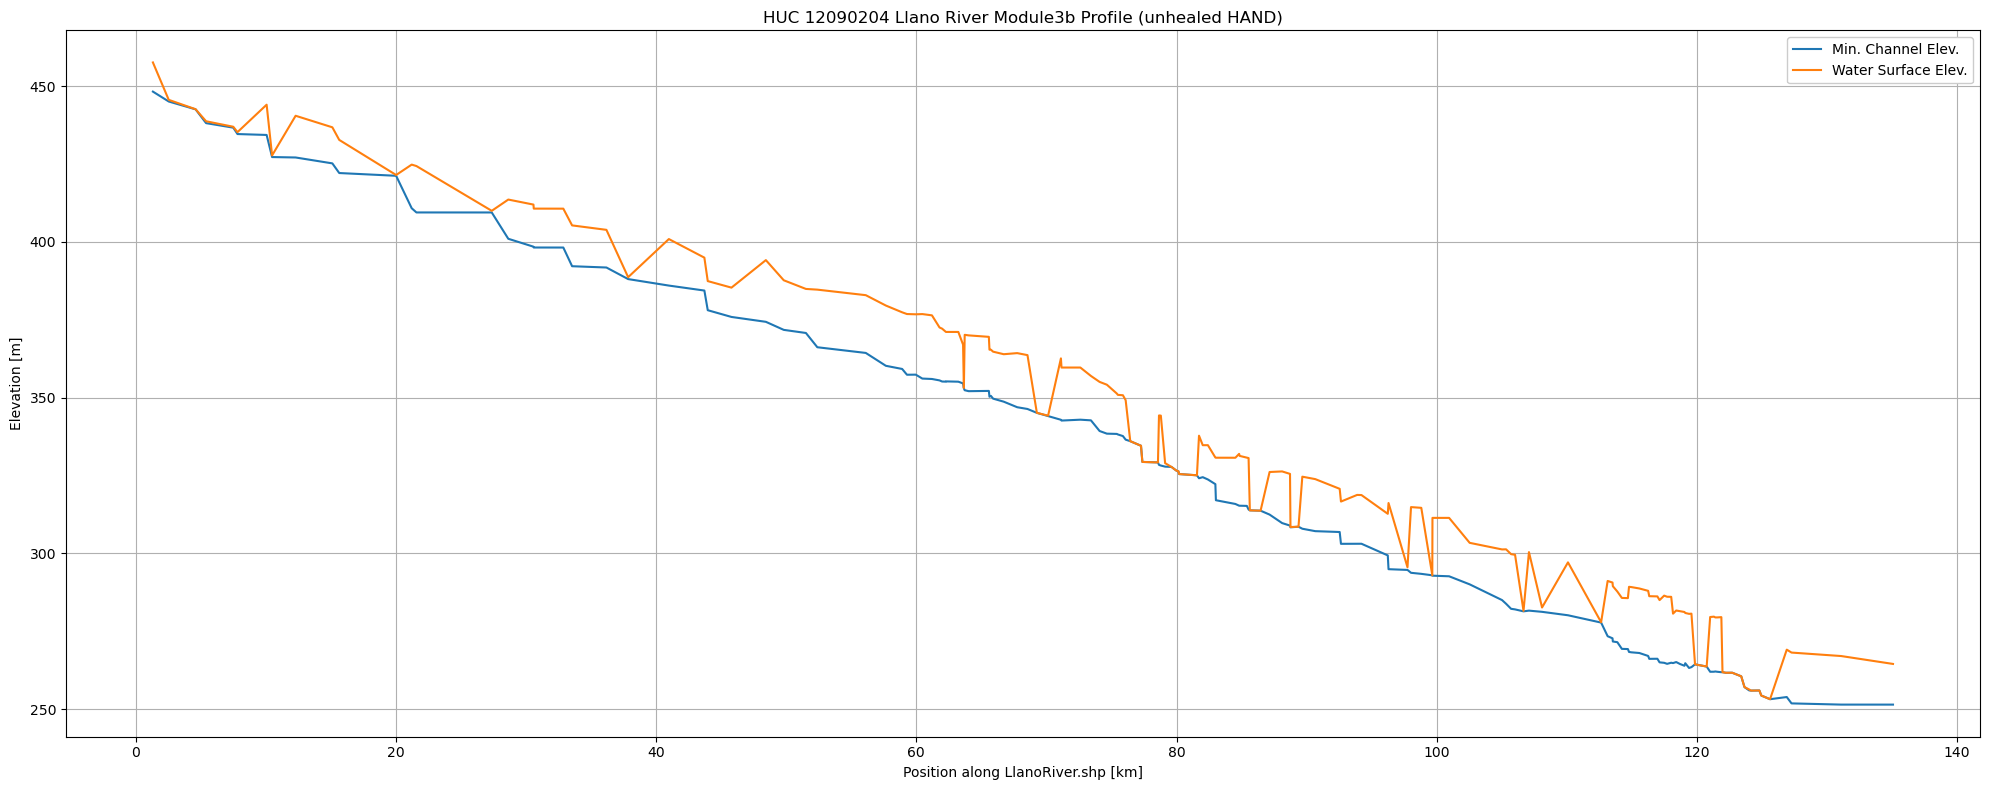

,position_km,LENGTHKM,Hydroseq,COMID,dem_min_channel_el,wse_mod1,wse_mod2a,wse_mod2b,wse_mod3a,wse_mod3b,...,wse_unhealed_mod2a,wse_unhealed_mod2b,wse_unhealed_mod3a,wse_unhealed_mod3b,peak_q_cms_mod1,peak_q_cms_mod2a,peak_q_cms_mod2b,peak_q_cms_mod3a,peak_q_cms_mod3b,peak_q_cms_mod3b
0,1.312,1.312,630006104.0,5769851,448.255920,451.219818,453.658203,456.706207,450.305420,457.620605,...,453.658203,456.706207,450.305420,457.620605,279.289994,851.579981,2181.399951,150.819997,2535.469943,2535.469943
1,2.529,1.217,630006073.0,5769843,445.079010,445.608795,445.304016,445.608795,445.608795,445.608795,...,445.304016,445.608795,445.608795,445.608795,280.119994,786.689982,2208.519951,155.239996,2542.479943,2542.479943
2,4.592,2.063,630006044.0,5769833,442.566010,442.604889,442.566010,442.566010,442.566010,442.604889,...,442.566010,442.566010,442.566010,442.604889,280.659994,674.809985,2247.039950,156.929996,2545.559943,2545.559943
3,4.592,2.063,630006044.0,5769833,442.566010,442.604889,442.566010,442.566010,442.566010,442.604889,...,442.566010,442.566010,442.566010,442.604889,280.659994,674.809985,2247.039950,156.929996,2545.559943,2545.559943
4,4.592,2.063,630006044.0,5769833,442.566010,442.604889,442.566010,442.566010,442.566010,442.604889,...,442.566010,442.566010,442.566010,442.604889,280.659994,674.809985,2247.039950,156.929996,2545.559943,2545.559943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23594,135.075,3.985,630003407.0,5771837,251.435089,255.047791,256.876587,264.496582,255.047791,264.496582,...,256.876587,264.496582,255.047791,264.496582,531.239988,1042.599977,7085.089842,512.669989,7312.279837,7312.279837
23595,135.075,3.985,630003407.0,5771837,251.435089,255.047791,256.876587,264.496582,255.047791,264.496582,...,256.876587,264.496582,255.047791,264.496582,531.239988,1042.599977,7085.089842,512.669989,7312.279837,7312.279837
23596,135.075,3.985,630003407.0,5771837,251.435089,255.047791,256.876587,264.496582,255.047791,264.496582,...,256.876587,264.496582,255.047791,264.496582,531.239988,1042.599977,7085.089842,512.669989,7312.279837,7312.279837
23597,135.075,3.985,630003407.0,5771837,251.435089,255.047791,256.876587,264.496582,255.047791,264.496582,...,256.876587,264.496582,255.047791,264.496582,531.239988,1042.599977,7085.089842,512.669989,7312.279837,7312.279837


In [3]:
if not os.path.isdir("figs"):
    os.mkdir("figs")

llano_gdf = gpd.read_file("LlanoRiver.shp")
llano_gdf.index = llano_gdf["Hydroseq"]
llano_gdf = llano_gdf.sort_index(ascending=False)
llano_gdf["position_km"] = llano_gdf["LENGTHKM"].cumsum()

mods = ["1", "2a", "2b", "3a", "3b"]
healed = ["healed", "unhealed_"]

with rio.open("dem_meters.tif", "r") as src:
    pts = get_points(llano_gdf, src.crs)
    llano_gdf["dem"] = sample_rio_ds(src, pts)

# create dataframe to save to csv later
df = pd.DataFrame()
df['position_km'] = round(llano_gdf['position_km'],3)
df['LENGTHKM'] = llano_gdf['LENGTHKM']
df['Hydroseq'] = llano_gdf['Hydroseq']
df['COMID'] = llano_gdf['COMID']
df['dem_min_channel_el'] = llano_gdf['dem']

for heal_status in healed:
    for mod in mods:
        inun_path = f"inundation/mod{mod}/mod{mod}_{heal_status}_mosaic.tif"
        with rio.open(inun_path, "r") as src:
            pts = get_points(llano_gdf, src.crs)
            llano_gdf[f"inun_{heal_status}mod{mod}"] = sample_rio_ds(src, pts)
            llano_gdf[f"wse_{heal_status}mod{mod}"] = (
                llano_gdf[f"inun_{heal_status}mod{mod}"] + llano_gdf["dem"]
            )

        df[f"wse_{heal_status}mod{mod}"] = llano_gdf[f"wse_{heal_status}mod{mod}"]

        if heal_status == "healed":
            plt.figure(figsize=(20, 8))
            plt.plot(
                llano_gdf["position_km"],
                llano_gdf["dem"],
                label="Min. Channel Elev.",
            )
            plt.plot(
                llano_gdf["position_km"],
                llano_gdf[f"wse_{heal_status}mod{mod}"],
                label="Water Surface Elev.",
            )            
            plt.xlabel("Position along LlanoRiver.shp [km]")
            plt.ylabel("Elevation [m]")
            plt.title(f"HUC 12090204 Llano River Module{mod} Profile (healed HAND)")
            plt.legend(framealpha=1.0)
            plt.grid()
            plt.tight_layout()
            plt.savefig(f'figs/wse_prof_healed_mod{mod}.png')
            plt.show()
            
        else:
            plt.figure(figsize=(20, 8))
            plt.plot(
                llano_gdf["position_km"],
                llano_gdf["dem"],
                label="Min. Channel Elev.",
            )
            plt.plot(
                llano_gdf["position_km"],
                llano_gdf[f"wse_{heal_status}mod{mod}"],
                label="Water Surface Elev.",
            )            
            plt.xlabel("Position along LlanoRiver.shp [km]")
            plt.ylabel("Elevation [m]")
            plt.title(f"HUC 12090204 Llano River Module{mod} Profile (unhealed HAND)")
            plt.legend(framealpha=1.0)
            plt.grid()
            plt.tight_layout()
            plt.savefig(f'figs/wse_prof_unhealed_mod{mod}.png')   
            plt.show()

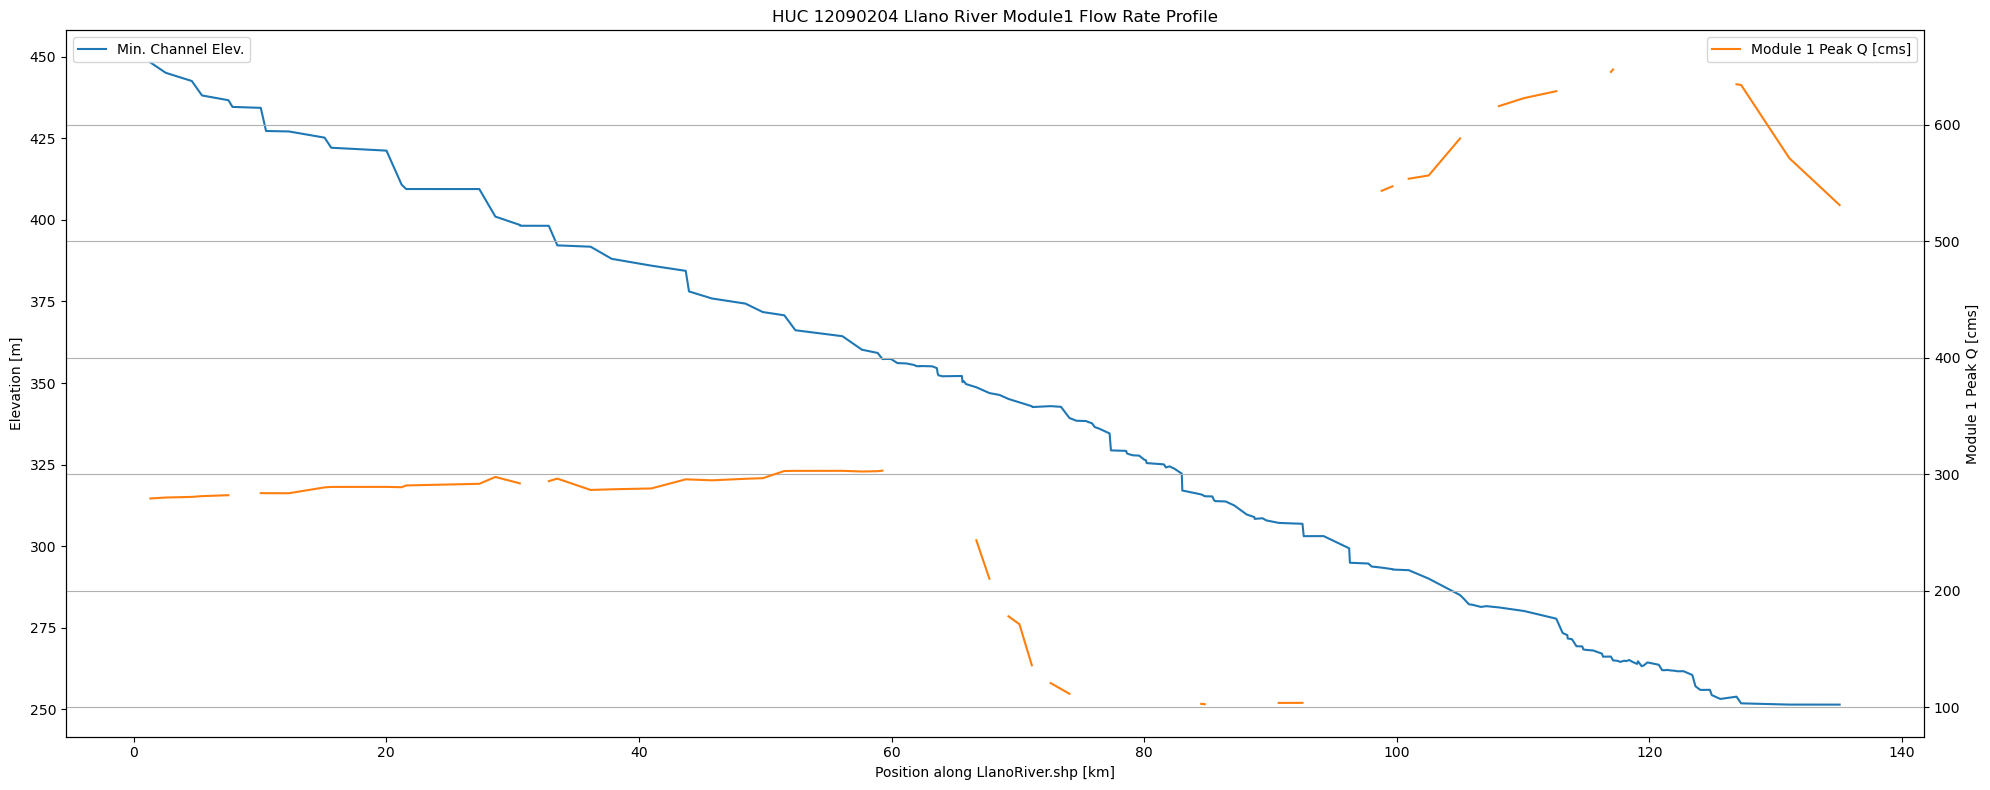

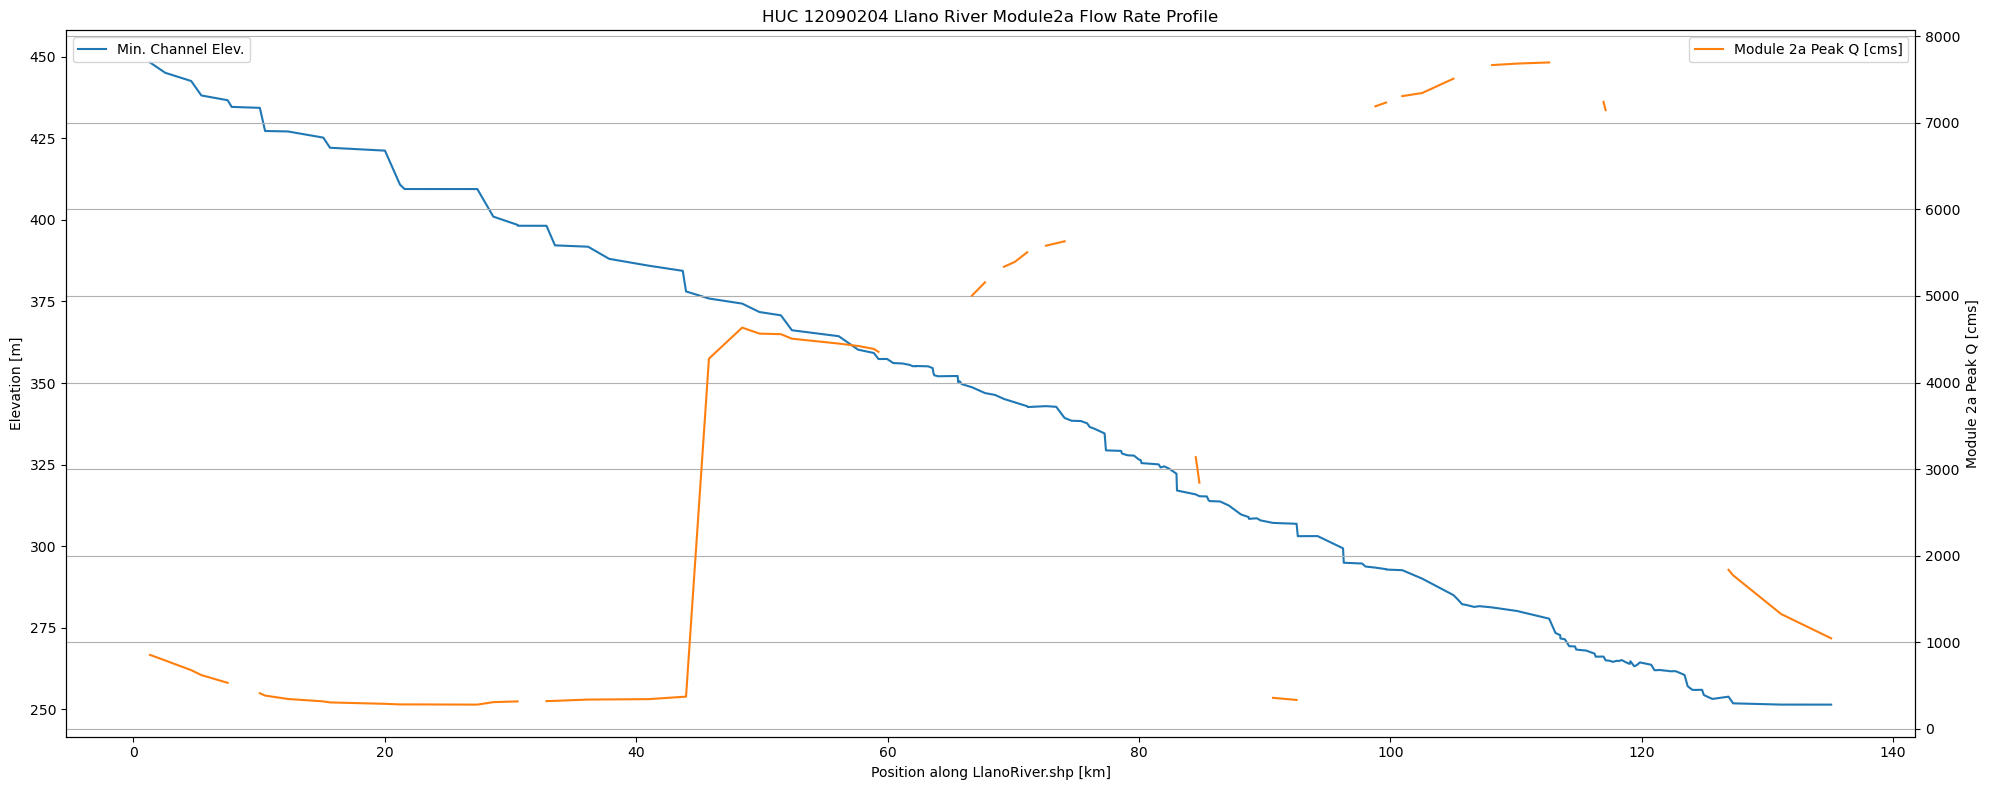

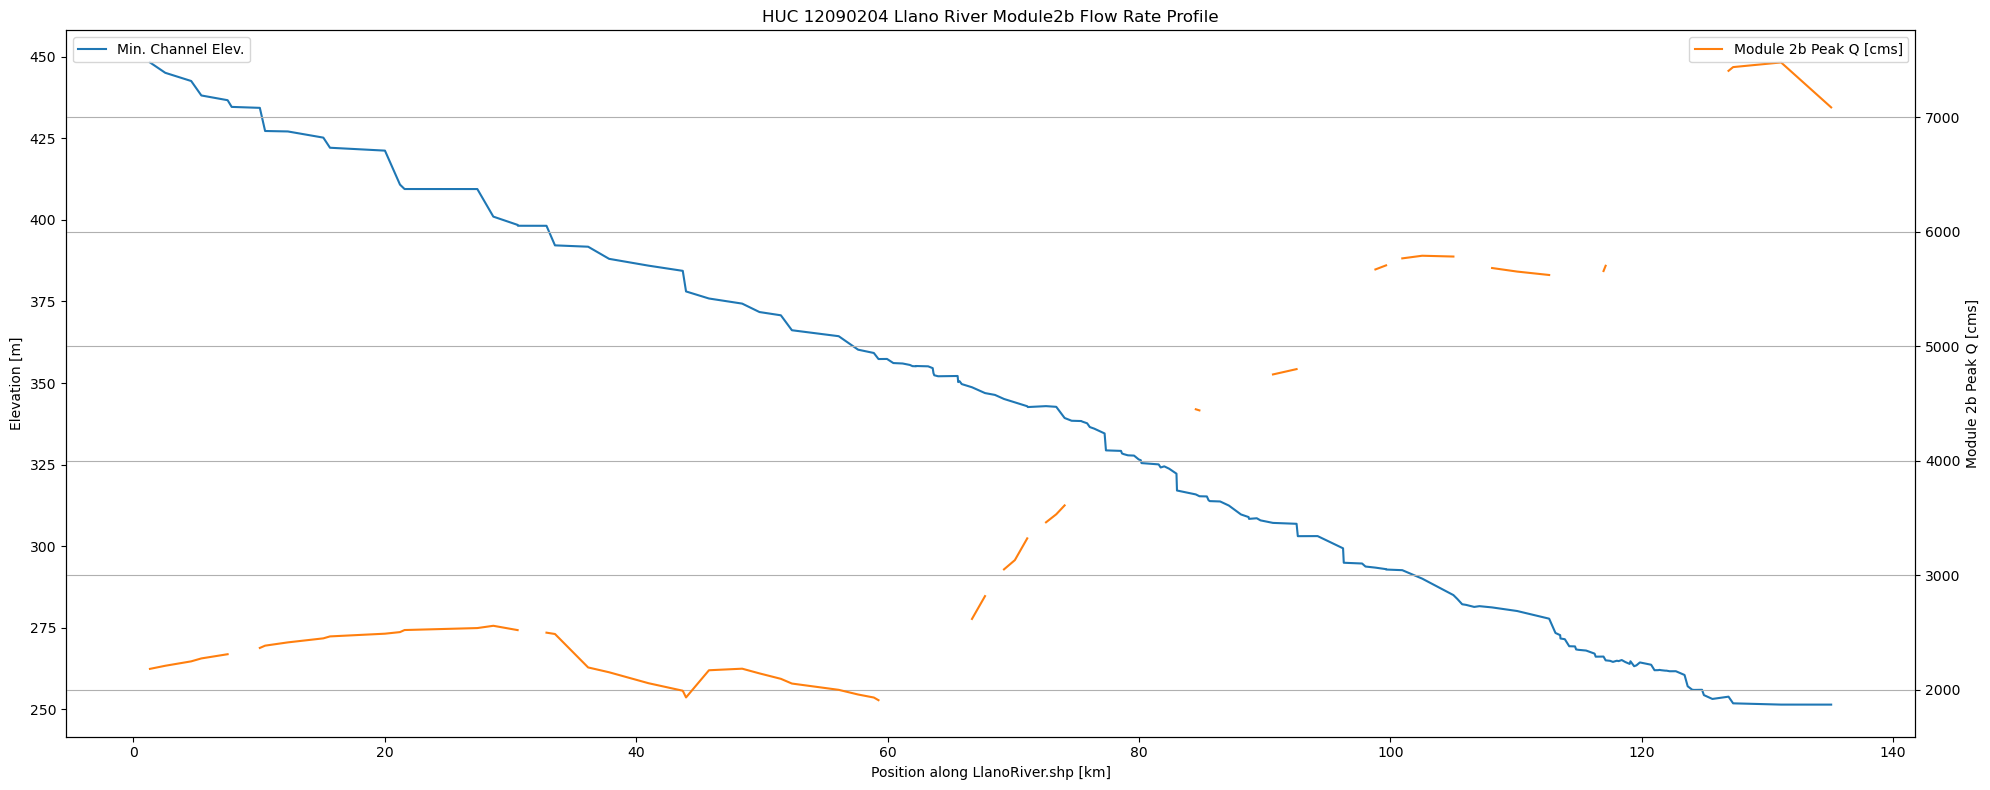

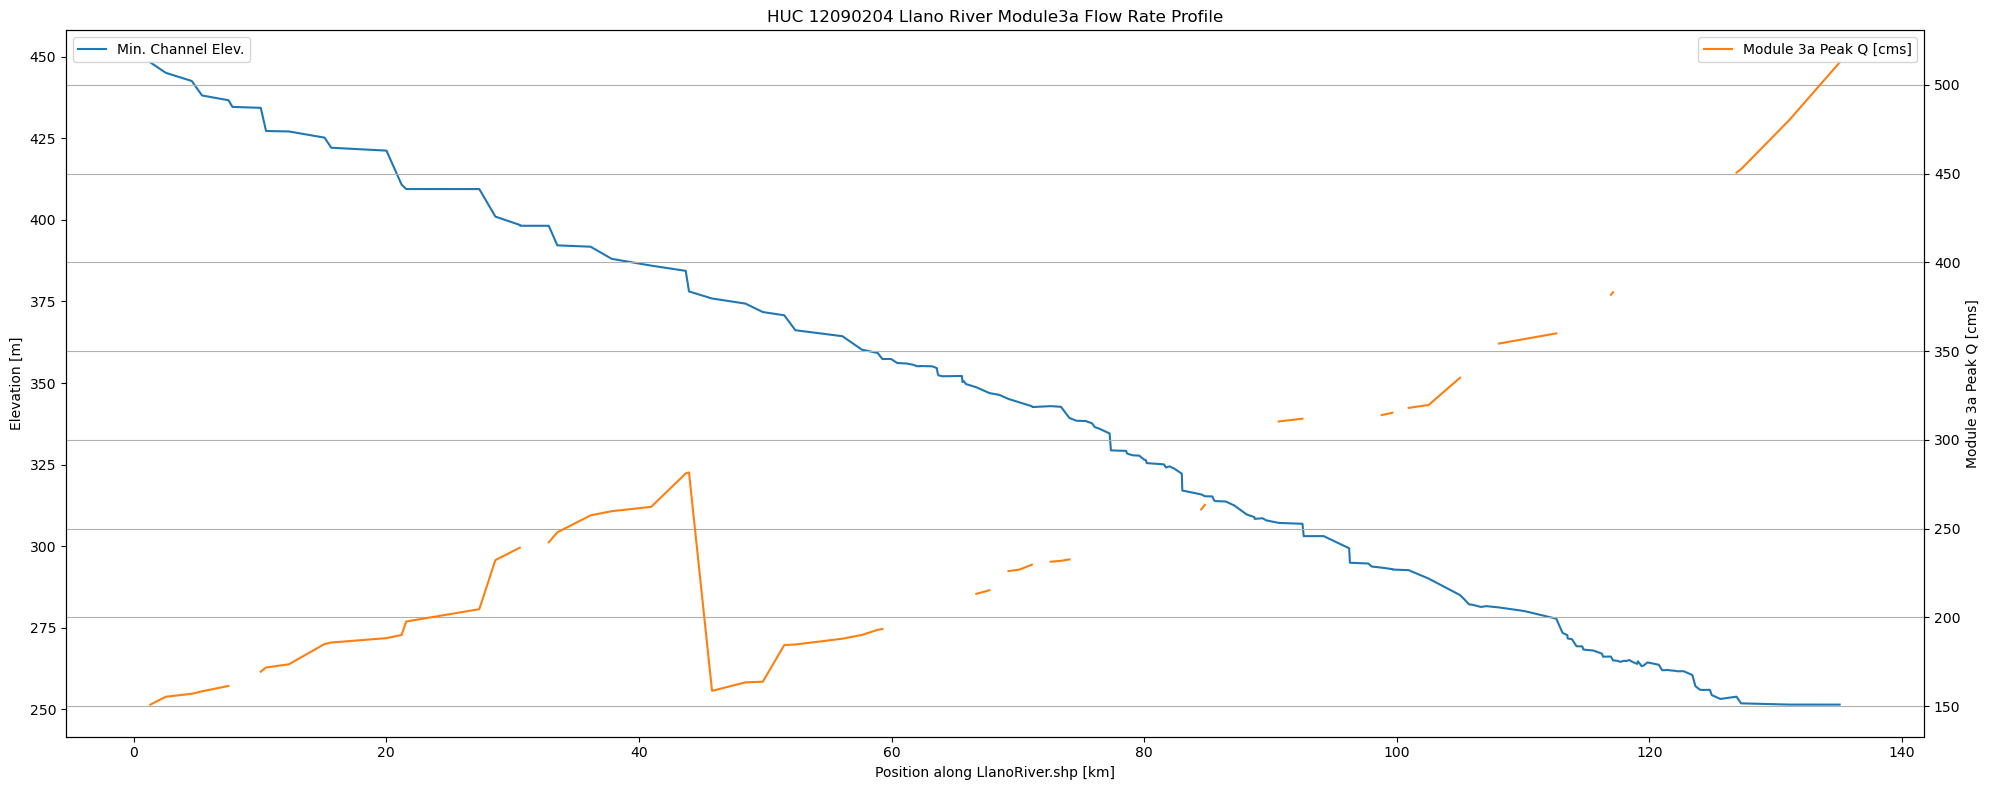

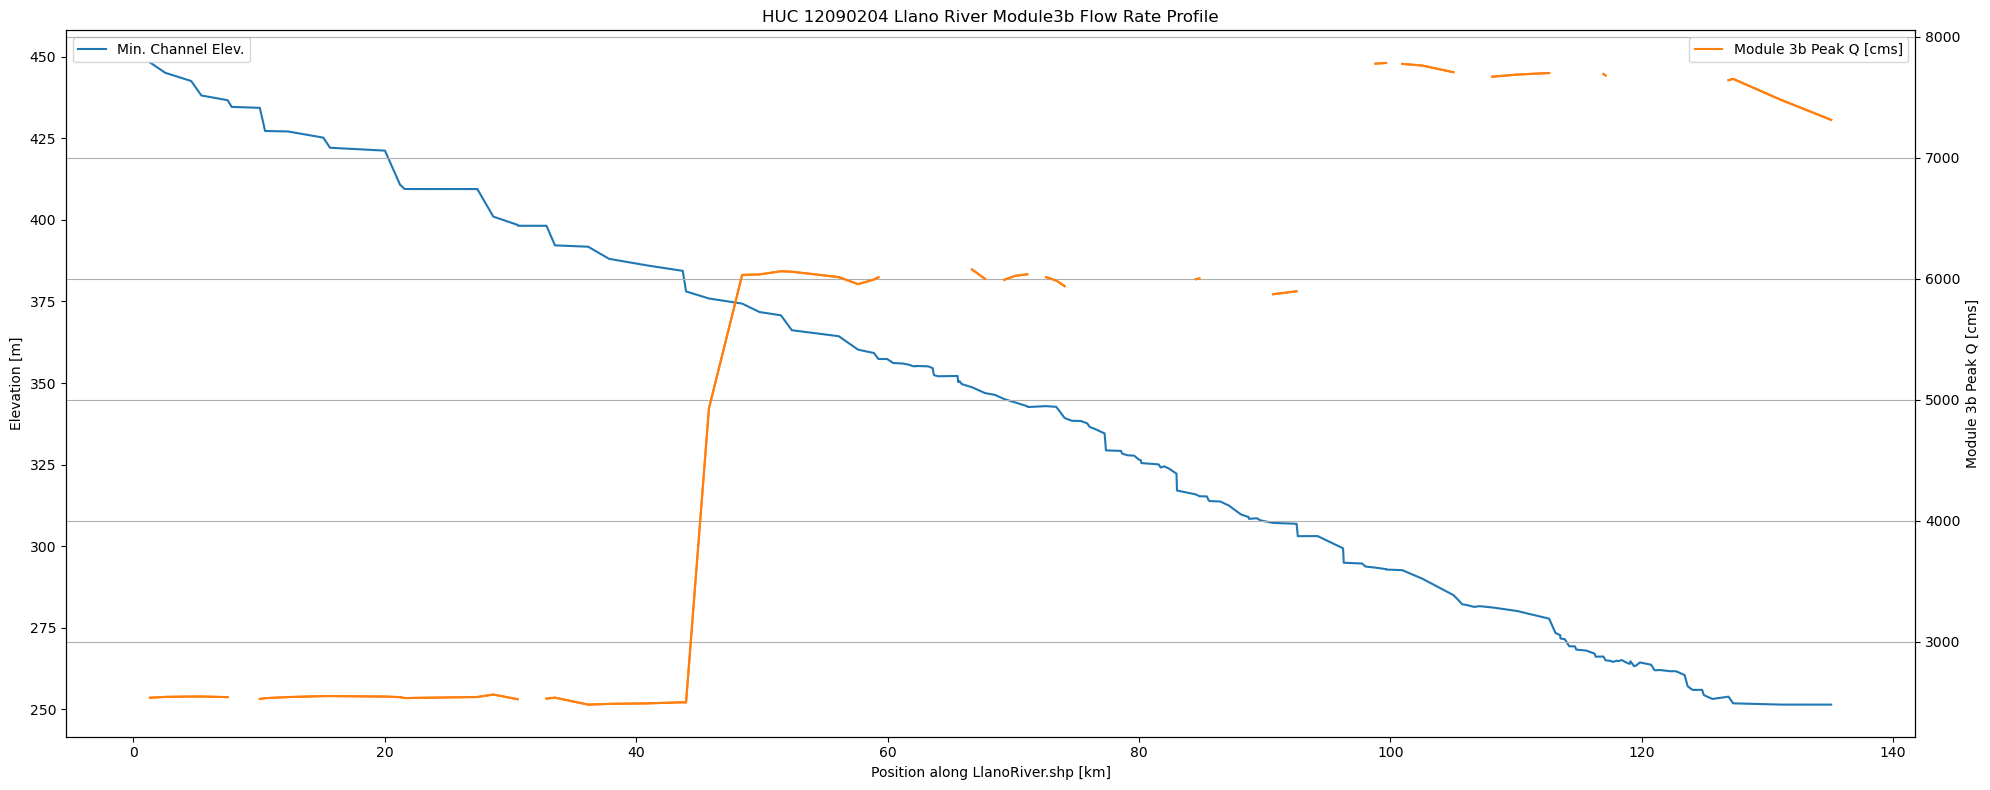

In [5]:
for mod in mods:

    fig, ax = plt.subplots(figsize=(20, 8))

    ax.plot(
        df["position_km"],
        df["dem_min_channel_el"],
        label="Min. Channel Elev.",
    )
    ax.set_xlabel("Position along LlanoRiver.shp [km]")
    ax.set_ylabel(f"Elevation [m]")
    ax.legend(framealpha=0.8, loc="upper left")
    plt.title(f"HUC 12090204 Llano River Module{mod} Flow Rate Profile")

    ax2 = ax.twinx()
    ax2.plot(
        df["position_km"],
        df[f"peak_q_cms_mod{mod}"],
        label=f"Module {mod} Peak Q [cms]",
        color="tab:orange",
    )
    ax2.set_ylabel(f"Module {mod} Peak Q [cms]")

    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend([handles[0]], [labels[0]], framealpha=0.8, loc="upper right")
    ax2.grid()

    ax2.set_axisbelow(True)
    plt.tight_layout()
    plt.savefig(f"figs/flowrate_prof_mod{mod}.png")
    plt.show()


In [ ]:
# export profile values to csv
# join dishcarge values from AustinExerciseModules.zip                     

module1_df = pd.read_csv(
    "../AustinExerciseModules/module1_stage_flow_15Oct2022_4pm_predicted_peak_flow.csv"
)

module2a_df = pd.read_csv(
    "../AustinExerciseModules/module2a_stage_flow_nwm.t15z.analysis_assim.channel_rt.tm00.aus_txdot.csv"
)

module2b_df = pd.read_csv(
    "../AustinExerciseModules/module2b_stage_flow_nwm.t15z.short_range.channel_rt.f006.aus_txdot.csv"
)

module3a_df = pd.read_csv(
    "../AustinExerciseModules/module3a_stage_flow_nwm.20181018_flow.analysis_assim_t15z.channel_rt.tm00.aus_txdot.csv"
)

module3b_df = pd.read_csv(
    "../AustinExerciseModules/module3b_stage_flow_nwm.20181014_20181019_peakflow.analysis_assim.channel_rt.tm00.aus_txdot.csv"
)

mod_dfs = [
    module1_df,
    module2a_df,
    module2b_df,
    module3a_df,
    module3b_df,
]

mod_dfs = [mod_df.rename(columns={"feature_id":"COMID"}) for mod_df in mod_dfs]

df = pd.merge(df, mod_dfs[0][["COMID", "peak_q_cms"]], on="COMID", how="left")
df = df.rename(columns={"peak_q_cms":"peak_q_cms_mod1"})

df = pd.merge(df, mod_dfs[1][["COMID", "peak_q_cms"]], on="COMID", how="left")
df = df.rename(columns={"peak_q_cms":"peak_q_cms_mod2a"})

df = pd.merge(df, mod_dfs[2][["COMID", "peak_q_cms"]], on="COMID", how="left")
df = df.rename(columns={"peak_q_cms":"peak_q_cms_mod2b"})

df = pd.merge(df, mod_dfs[3][["COMID", "peak_q_cms"]], on="COMID", how="left")
df = df.rename(columns={"peak_q_cms":"peak_q_cms_mod3a"})

df = pd.merge(df, mod_dfs[4][["COMID", "peak_q_cms"]], on="COMID", how="left")
df = df.rename(columns={"peak_q_cms":"peak_q_cms_mod3b"})
df = pd.merge(df, mod_dfs[4][["COMID", "peak_q_cms"]], on="COMID", how="left")
df = df.rename(columns={"peak_q_cms":"peak_q_cms_mod3b"})

df.to_csv('profiles_with_q.csv',index=False)